# Laboratorium - Object Detection

Przedmiot: SISI

Autor: Rafał Stachura

kontakt: rafstach.97@gmail.com

## Wprowadzenie

Celem ćwiczenia jest zapoznanie się z technologią Object Detection. W ćwiczeniu zostanie wykorzystany gotowy model detekcji pretrenowany na zbiorze COCO. Rozpoznawanie obiektów na obrazie będzie realizowane z wykorzystaniem TensorFlow Lite, a do przetwarzania obrazów zostanie użyta biblioteka OpenCV. Ćwiczenie zostało podzielone na dwie części. W pierszej zostanie detekcja na statycznych obrazach, natomiast w drugiej części zostanie zrealizowane rozpoznawanie obiektów na żywo z wykorzystaniem kamery internetowej. Z powodu konieczności dostępu do kamery zalecana jest realizacja laboratorium na urządzeniu lokalnym.

#### Zbiór danych COCO
Informacje o zbiorze danych: http://cocodataset.org/#home

#### Zbiór gotowych modeli detekcji dla Tensorflow
Źródło: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md

#### Tensorflow Object Detection API
Informacje na temat dostepnego API i jego konfiguracji: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md

## Wstęp teoretyczny i omówienie narzędzi

### Object Detection
Detekcja obiektów na obrazie należy do zagadnień związanych z Computer Vision. Jest to technologia powiązana z przetwarzaniem obrazów, która pozwala rozpoznać na wejściowym obrazie obiekty należące do określonej klasy pochodzącej ze znanego zbioru. Wejściem dla modeli Object Detection mogą być nie tylko obrazy, ale również strumienie wideo. Algorytm po przetworzeniu danej ramki zwraca informację, które z obiektów ze zdefiniowanego zbioru zostały rozpoznane i jednocześńnie podaje ich pozycję np. w postaci listy ramek. Dosepna jest również informacja o pewności z jaką rozpoznanym obiektom została przypisana dana klasa.

#### Przykłady zastosowań:
- Adnotowanie obrazów
- Detekcja i rozpoznawanie twarzy
- Aktywne rozpoznawanie obiektów

### TensoFlow Lite
Jest to framework dla uczenia maszynowego przeznaczony dla urządzeń o ogranicoznych zasobach sprzętowych. Narzędzie dostarcza wszystkich potrzebnych narzędzi, potrzebnych do konwersji oraz uruchamiania modeli TensorFlow na urządzeniach mobilnych, sprzecie klasy embeded oraz szeroko pojętych urządzeniach IoT. Jest często wykorzystywany w Edge Computing.  
Dowiedz się więcej: https://www.tensorflow.org/lite

### OpenCV
Wieloplatformowa biblioteka do przetwarzani obrazów posiadająca interfejsy programistyczne w wielu językach np. Python, Java. Narzędzie gładzie ancisk na przetwarzanie obrazów  wczasie rzeczywistym.
Dowiedz się więcej: https://opencv.org/

### Ogólna zasada działania frameworków Object Detection
1. Model głębokiego uczenia maszynowego lub stosowny algorytm dokonuje podziału obrazu za pomocą wygenerowanego, zazwyczaj bardzo licznego, zbioru ramek ograniczających elementy na obrazie. Fragment algorytmu odpowiedzialny za generowanie zbioru ograniczających ramek nazywany jest komponentem lokalizacyjnym.
<img src="doc-img/divided_picture.png" width="300" height="300">

2. Dla każdej wydzielonej ramki nastepuje ekstrakcja cech. Komponnt klasyfikacji dla każdego fragmentu dokonuje ewaluacji czy wewnątrz określonej ramki znajduje się obiekt, a jeżeli, tak, to jaki.
<img src="doc-img/feature_extraction_picture.png" width="300" height="300">

3. W ostatnim kroku nachodzące ramki są redukowane do pojedynczych komponentów, dla których został przewidziany określony obiekt na ilustracji.
<img src="doc-img/objct_detected_picture.png" width="300" height="300">

Źródło ilustracji: https://www.analyticsvidhya.com/blog/2020/04/build-your-own-object-detection-model-using-tensorflow-api/

### Sieć neuronowa MobileNet-SSD

#### SSD - Single Shot MultiBox Detector
Architektura modelu SSD została omówiona w artykule SSD: Single Shot MultiBox Detector(https://arxiv.org/abs/1512.02325)z 2016 roku. Nazwa modelu zawiera następujce informacje:
- Single Shot - zadanie lokalizacji obiektów na zdjęciu i ich klasyfikacja jest realizowana w pojedynczym przebiegu sieci neuronowej
- MultiBox - odnosi się do techniki przewidywania ramek rozwijanej przez Szegedy.
- Detector - sieć neuronowo dokonuje detekcji obiektów i je kalsyfikuje

#### Architektura sieci
<img src="doc-img/mobile_net_architecture.png" width="900" height="400">
Źródło ilustarcji: https://towardsdatascience.com/understanding-ssd-multibox-real-time-object-detection-in-deep-learning-495ef744fab

Architektura sieci SSD jest pojedynczą siecią konwolucyjną zdolną do przewidywania, położenia ramek ograniczających i klasyfikowania ich w czasie pojedynczego przebiegu. Sieć SSD skłąda się z bazowej architektury (MobileNet) oraz kilku warstw konwolucyjnych nastepująccyh po niej.

Sieć operuje na mapie cech, by wykryć ramki ograniczające. Sieć nie przewiduje kształtu ramki, a jedynie jej położenie na ilustracji. Każda z K wygenerowanych ramek dla każdej z mapy cech posiada predefiniowany kształt.

## Konfiguracja środowiska

Lokalna konfiguracja środowiska obejmuje instalację niezbędnych pakietów oraz ich zaimportowanie. W drugej części ćwiczenia potrzbna będzie kamera internetowa - można wykorzystać tą dostępną w laptopie. W przypadku problemów z dostępem do urządzenia należy zwrócić uwage na nadanie stosownych uprawnień.

### Import niezbędnych pakietów

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import pathlib
from IPython.display import clear_output

print(tf.__version__)

2.1.0


Konfiguracja środowiska

In [2]:
%pylab inline 

try:
  %tensorflow_version 2.x
except:
  pass

Populating the interactive namespace from numpy and matplotlib


## Przykład użycia
Przykład obejmuje załadnowanie przykładowych obrazów oraz identyfikację przedstawionych na nich obiektów.

### Przygotowanie modelu

Należy pobrać wytrenowany model dla TensorFlow Lite dostepny pod adresem: https://storage.googleapis.com/download.tensorflow.org/models/tflite/coco_ssd_mobilenet_v1_1.0_quant_2018_06_29.zip, a następnie wypakować go do katalogu model. Po rozpakowaniu w katalogu pojawią się dwa pliki: 
- detect.tflit - model sieci neuronowej coco_ssd_mobilenet_v1_1.0_quant wytrenowanej i poddanenej kwantyzacji. Jest to model należący do klasy MobileNets, cyli modeli obejmujących konwolucyjne sieci neuronowe dla urzadzeń mobilnych.
- labelmap.txt - plik tekstowy zawierajacy zorganizowane w pojedynczej kolumnie etykiety klas obiektów rozpoznawanych przez model(uwaga, pierwsza linia zawiera `???`, które są pomijane w dalszej części kodu)

#### Wczytanie modelu i alokacja tensorów

In [3]:
# Załadowanie wytrenowanego modelu TFLite
path = 'model/detect.tflite'
interpreter = tf.lite.Interpreter(model_path=path)

# Alokacja tensorów
interpreter.allocate_tensors()

#### Wyświetlenie informacji o tensorach wejściowych i wyjściowych

In [4]:
# Pobierz informacje o wejściowych i wyjściowych tensorach

# Odkomentować w wersji studenckiej
# input_details = ?
# output_details = ?

#Oczekiwane rozwiązanie
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Tensory wejściowe:\n",input_details)
print("Tensory wyjściowe:\n",output_details)

Tensory wejściowe:
 [{'name': 'normalized_input_image_tensor', 'index': 175, 'shape': array([  1, 300, 300,   3]), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0078125, 128)}]
Tensory wyjściowe:
 [{'name': 'TFLite_Detection_PostProcess', 'index': 167, 'shape': array([ 1, 10,  4]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}, {'name': 'TFLite_Detection_PostProcess:1', 'index': 168, 'shape': array([ 1, 10]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}, {'name': 'TFLite_Detection_PostProcess:2', 'index': 169, 'shape': array([ 1, 10]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}, {'name': 'TFLite_Detection_PostProcess:3', 'index': 170, 'shape': array([1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]


#### Interpretaja informacji o tensorach
Na podstawie wypisanych informacji określ, jaki jest oczekiwany przez model wejściowy format obrazu oraz w jakiej postaci są zwracane wynki.

Wejście modelu:
 - szerokość wejściowa = ? //300
 - wysokość wejściowa = ? // 300
 - format piksela = ? //rgb

Wyjście modelu:
 - format wyjściowy = ? // ramki  określające położenie obiektu

#### Wczytanie etykiet obiektów rozpoznawanych przez model

In [5]:
# Odczyt etykiet
path_to_labels = 'model/labelmap.txt'

with open(path_to_labels, 'r') as file:
    labels = [line.strip() for line in file.readlines()]

# Usunięcie nagłówka z pliku    
if labels[0] == '???':
    del(labels[0])

#### Zapoznanie z listą rozpoznawanych obiektów
Wypisz kilka przykładowych etykiet

In [6]:
# ?
# Usunąć w wersji studenckiej
np.array(labels)[0:10]

array(['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
       'train', 'truck', 'boat', 'traffic light'], dtype='<U14')

#### Wczytanie obrazu wejściowego do detekcji obrazu
Po wczytaniu obrazu należy dostosować jego rozmiar do formatu akceptowanego przez przez model

In [7]:
# Wczytanie obrazu
image_path = 'images/computer.png'
img = cv2.imread(r"{}".format(pathlib.Path(image_path).resolve()))
    
# Dopasuj kształt obrazu do formatu akceptowanego przez model
# Odkomentować w wersji studenckiej
# img_reshaped = ?
img_reshaped = cv2.resize(img, (300, 300))

#### Uruchomienie modelu Object Detection

In [8]:
# Ustawienie tensorów
interpreter.set_tensor(input_details[0]['index'], [img_reshaped])

# Uruchomienie interpretera
interpreter.invoke()

# Odczyt rezultatów
rectangles = interpreter.get_tensor(output_details[0]['index'])
classes = interpreter.get_tensor(output_details[1]['index'])
scores = interpreter.get_tensor(output_details[2]['index'])

print(rectangles)
print(scores)
print(classes)

[[[ 0.14809573  0.30314285  0.57909644  0.77701765]
  [ 0.13584289 -0.00234103  0.7962525   0.27592713]
  [ 0.6496609   0.27141908  0.7684035   0.907462  ]
  [ 0.6544368   0.38669217  0.74279773  0.8803977 ]
  [ 0.51823425  0.0134017   0.7690197   0.2716472 ]
  [ 0.16821927  0.19377878  0.76761925  0.8724085 ]
  [ 0.18516573  0.43858016  0.6161665   0.79129815]
  [ 0.15562253  0.30035827  0.42523187  0.75228786]
  [ 0.6298785   0.35913348  0.7089846   0.84509706]
  [ 0.7272335   0.18582633  0.95424175  0.9547049 ]]]
[[0.78515625 0.48828125 0.4609375  0.40234375 0.35546875 0.28125
  0.25       0.2421875  0.234375   0.234375  ]]
[[71. 76. 75. 75. 71. 71. 71. 71. 75. 75.]]


#### Zapoznanie z wynikami

Jaka jest postać wyników działania modelu detekcji elementów na obrazie? W jaki sposób można wykorzystać otrzymane informacje do wizualizacji efektów działania modelu?

?

#### Funkcja pomocnicza zazaczająca prostokątny obszar na obrazie

In [9]:
def draw_rectangle(image, box, recognized_class, result_score):
    img_height = image.shape[0]
    img_width = image.shape[1]
    y_min = int(max(1, (box[0] * img_height)))
    x_min = int(max(1, (box[1] * img_width)))
    y_max = int(min(img_height, (box[2] * img_height)))
    x_max = int(min(img_width, (box[3] * img_width)))
    
    # Zaznaczenie prostokątnego obszaru an obrazie
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)
    
    # Dodanie etykiety obiektu do obrazu
    object_name = labels[int(recognized_class)]
    label = '%s: %d%%' % (object_name, int(result_score*100))
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) 
    label_ymin = max(y_min, labelSize[1] + 10)
    cv2.rectangle(image, (x_min, label_ymin-labelSize[1]-10), (x_min+labelSize[0], label_ymin+baseLine-10), (0, 255, 0), cv2.FILLED)
    cv2.putText(image, label, (x_min, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) 

#### Detekcja obiektów na przykłądowych obrazach
Przeprowadzana jest detekcja obeiktów na obrazach dla wszystkich obrazów z katalogu images. Naciśnij klawisz, aby zmienić obraz.

In [10]:
images_dir_path = 'images'
min_accuracy = 0.50
images_after_object_detection = []

for file in pathlib.Path(images_dir_path).iterdir():
    # Odczyt obrazu i dopasowanie rozmiatu
    img = cv2.imread(r"{}".format(file.resolve()))
    img_reshaped = cv2.resize(img, (300, 300))

    # Uruchomienie modelu
    interpreter.set_tensor(input_details[0]['index'], [img_reshaped])
    interpreter.invoke()
    
    # Pobranie rezultatów
    rectangles = interpreter.get_tensor(output_details[0]['index'])[0]
    classes = interpreter.get_tensor(output_details[1]['index'])[0]
    scores = interpreter.get_tensor(output_details[2]['index'])[0]
    
    # Dodanie zaznaczenia dla wszystkich obiektów o accuracy > 0.5
    for index, score in enumerate(scores):
        if score > min_accuracy:
            draw_rectangle(img_reshaped, rectangles[index], classes[index], scores[index])
    
    # Zmiana formatu piksela
    img_reshaped = cv2.cvtColor(img_reshaped, cv2.COLOR_BGR2RGB)    
    images_after_object_detection.append(img_reshaped)



for img in images_after_object_detection:
    imshow(img, aspect ='auto')
    show()
    clear_output(wait=True)
    input("Wciśnij enter aby kontynuować...")

Wciśnij enter aby kontynuować...


#### Odczyt obrazu z kamery internetowej

In [17]:
# Ustalenie wejściowego obrazu z kamery internetowej (opcjonalnie można jako argument podać ścieżkę do filmu np. mp4)
video = cv2.VideoCapture(0)

# Obraz jest wyświetlany w notatniku na żywo do momentu przerwania
try:
    while(True):
        # Pobranie pojedynczej ramki
        ret, frame = video.read()
        
        if not ret:
            video.release()
            print("Zasób wideo został zwolniony")
            break
            
        # Konwersja formatu obrazu
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        axis('off')
        title("Obraz wideo")
        
        # Wyświetlenie pojedynczej ramki
        imshow(frame, aspect ='auto')
        show()
        clear_output(wait=True)
except KeyboardInterrupt:
    # Zwolnienie zasobu po zakończeniu odczytu obrazu
    video.release()
    print("Zasób wideo został zwolniony") 


Zasób wideo został zwolniony


#### Object Detection - na żywo

Na podstawie przedstawionych fragmentów należy przygotować kod, który będzie realizował detekcję obiektów na obrazie pobieranym z kamery na żywo.

#### Funkcja pomocnicza realizująca detekcję obiektów na pojedynczej ramce
Należy zaimplementować funkcję

In [12]:
# Odkomentować w wersji studenckiej
# def object_detection_on_single_frame(frame):
#    ?

def object_detection_on_single_frame(frame):
    img_reshaped = cv2.resize(frame, (300, 300))

    # Uruchomienie modelu
    interpreter.set_tensor(input_details[0]['index'], [img_reshaped])
    interpreter.invoke()
    
    # Pobranie rezultatów
    rectangles = interpreter.get_tensor(output_details[0]['index'])[0]
    classes = interpreter.get_tensor(output_details[1]['index'])[0]
    scores = interpreter.get_tensor(output_details[2]['index'])[0]
    
    # Dodanie zaznaczenia dla wszystkich obiektów o accuracy > 0.5
    for index, score in enumerate(scores):
        if score > min_accuracy:
            draw_rectangle(img_reshaped, rectangles[index], classes[index], scores[index])
            
    return img_reshaped

#### Integracja algorytmu Object Detection z obrazem transmitowanym na żywo
Należy połączyć gragment kodu odczytujący obraz z kamery z funkcja dokonującą detekcji okbiektów na obrazie.

In [ ]:
# ?

Zasób wideo został zwolniony


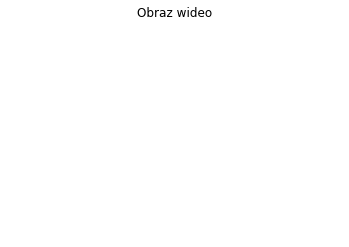

In [13]:
# Ustalenie wejściowego obrazu z kamery internetowej (opcjonalnie można jako argument podać ścieżkę do filmu np. mp4)
video = cv2.VideoCapture(0)

# Obraz jest wyświetlany w notatniku na żywo do momentu przerwania
try:
    while(True):
        # Pobranie pojedynczej ramki
        ret, frame = video.read()
        
        if not ret:
            video.release()
            print("Zasób wideo został zwolniony")
            break
            
        # Konwersja formatu obrazu z używanego przez OpenCV na standardową formę plaety
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        axis('off')
        title("Obraz wideo")
        
        # Przetworzenie ramki algorytmem detekcji obrazu i zaznaczenie znalezionych obiektów
        processed_img = object_detection_on_single_frame(frame)
        
        # Wyświetlenie pojedynczej ramki po zastosowaniu Object Detection
        imshow(processed_img, aspect ='auto')
        show()
        clear_output(wait=True)
except KeyboardInterrupt:
    # Zwolnienie zasobu po zakończeniu odczytu obrazu
    video.release()
    print("Zasób wideo został zwolniony") 
    

Źródła:
- https://www.analyticsvidhya.com/blog/2020/04/build-your-own-object-detection-model-using-tensorflow-api/
- https://towardsdatascience.com/understanding-ssd-multibox-real-time-object-detection-in-deep-learning-495ef744fab